100%|██████████| 9.91M/9.91M [00:00<00:00, 56.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.83MB/s]


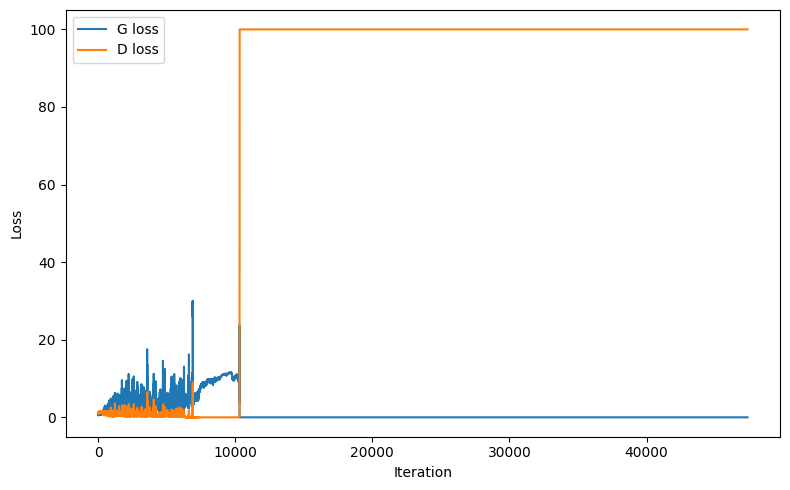

In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import os

# 1. Hyperparameters
batch_size = 128
lr = 2e-4
nz = 100       # latent dim
num_epochs = 100
sample_dir = 'samples'
os.makedirs(sample_dir, exist_ok=True)

# 2. Data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)

# 3. Generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self, z):
        out = self.net(z)
        return out.view(-1, 1, 28, 28)

# 4. Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# 5. Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
G = Generator().to(device)
D = Discriminator().to(device)
criterion = nn.BCELoss()
optG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, device=device)
g_losses, d_losses = [], []

# 6. Training loop
for epoch in range(num_epochs+1):
    for real, _ in loader:
        bs = real.size(0)
        real = real.to(device)
        # Labels
        real_labels = torch.ones(bs, 1, device=device)
        fake_labels = torch.zeros(bs, 1, device=device)

        # Train Discriminator
        z = torch.randn(bs, nz, device=device)
        fake = G(z)
        D_real = D(real)
        D_fake = D(fake.detach())
        lossD = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
        optD.zero_grad(); lossD.backward(); optD.step()

        # Train Generator
        D_fake2 = D(fake)
        lossG = criterion(D_fake2, real_labels)
        optG.zero_grad(); lossG.backward(); optG.step()

        g_losses.append(lossG.item())
        d_losses.append(lossD.item())

    # Save sample images at specified epochs
    if epoch in [0, 50, 100]:
        with torch.no_grad():
            samples = G(fixed_noise).cpu()
            grid = utils.make_grid(samples, nrow=8, normalize=True)
            utils.save_image(grid, f'{sample_dir}/epoch_{epoch}.png')

# 7. Plot losses
plt.figure(figsize=(8,5))
plt.plot(g_losses, label='G loss')
plt.plot(d_losses, label='D loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('loss_curve.png')
plt.show()
